# Data Exploration - Restaurants


Notebook for exploring the Restaurants dataset

## 1. Imports

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import regex as re
from sklearn.preprocessing import MultiLabelBinarizer
from collections import Counter
import seaborn as sns

In [54]:
dataset = pd.read_csv('../data_hyderabad/105_restaurants.csv')

## 2. Descriptions

In [55]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Name         105 non-null    object
 1   Links        105 non-null    object
 2   Cost         105 non-null    object
 3   Collections  51 non-null     object
 4   Cuisines     105 non-null    object
 5   Timings      104 non-null    object
dtypes: object(6)
memory usage: 5.0+ KB


In this dataset, we have the following issues:

- There is no restaurant ID, only names which may be repeated
- The links may contain useful information
- Cost should be an integer
- Collection only has values for 51 of the items - We should probably remove this. If we had more time, this section of items could be further analysed, or we could even try to categorize the missing values into these collections
- Cuisines is a list of keywords, should be encoded
- Timings is not usable by the machine, should be converted to a more usable format. There is also a missing value.

In what comes to the alterations on the timing column:
- A restaurant may be open only on weekdays/weekends
- Restaurants can be categorized into: Lunch, Dinner, Moonlight, Daylight, and All Day

For the collections column, we will first check if there is any correlation

In [56]:
dataset['Cost'] = dataset['Cost'].str.replace(',', '').astype(int)
dataset['Collections']  = dataset['Collections'].fillna(' ')
dataset['Collections'] = dataset['Collections'].apply(lambda content: [item.strip().lower() for item in re.split(",", content)])
dataset['Timings'] = dataset['Timings'].astype(str)

In [57]:
dataset.describe(exclude=int)

,Name,Links,Collections,Cuisines,Timings
count,105,105,105,105,105
unique,105,105,43,92,78
top,Beyond Flavours,https://www.zomato.com/hyderabad/beyond-flavou...,[],"North Indian, Chinese",11 AM to 11 PM
freq,1,1,54,4,6


In [58]:
dataset.describe()

,Cost
count,105.000000
mean,861.428571
std,510.149730
min,150.000000
25%,500.000000
50%,700.000000
75%,1200.000000
max,2800.000000


## 3. Collections

In [60]:
# Identify rows with "empty" lists (containing just an empty string)
rows_without_collection = dataset[dataset['Collections'].apply(lambda x: len(x) == 1 and x[0] == '')]
num_rows_without_collection = len(rows_without_collection)

# Print the number of rows with "empty" collections
print(f"Number of rows with empty collections (['']): {num_rows_without_collection}")

Number of rows with empty collections (['']): 54


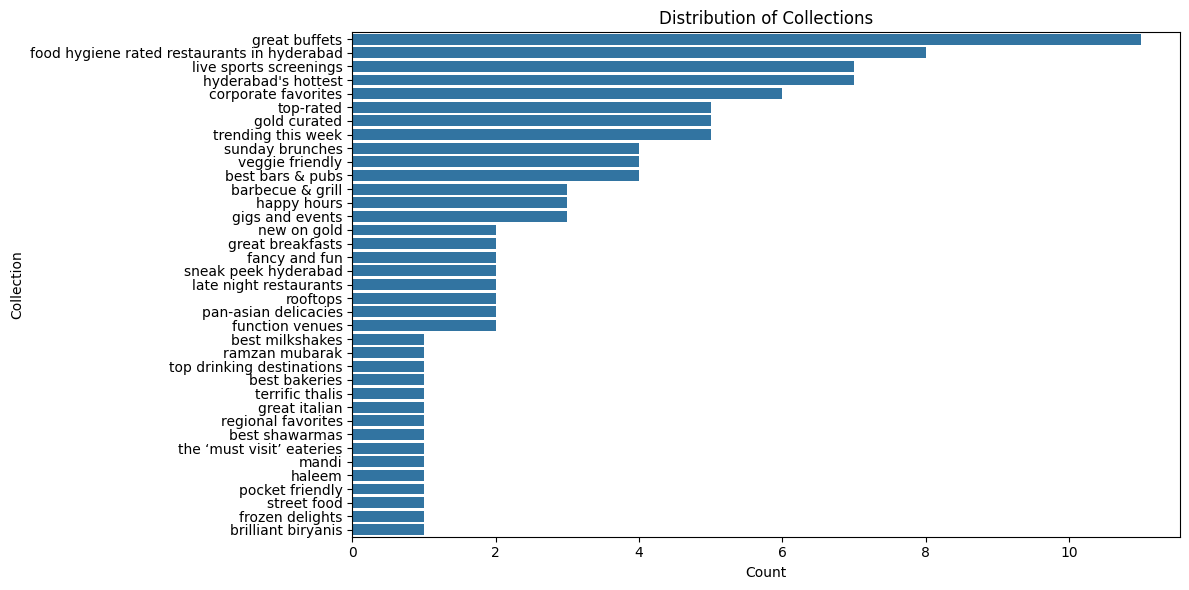

In [62]:
# Removes the empty rows
dataset = dataset[~dataset['Collections'].apply(lambda x: len(x) == 1 and x[0] == '')]

# Flattens the list of collections
all_collections = [collection for sublist in dataset['Collections'] for collection in sublist]

# Counts occurrences of each collection
collection_counts = Counter(all_collections)

# Converts to dataframe for easier plotting
collectionsdf = pd.DataFrame(collection_counts.items(), columns=['Collection', 'Count'])
collectionsdf = collectionsdf.sort_values(by='Count', ascending=False)

# Plot the distribution
plt.figure(figsize=(12, 6))
sns.barplot(x='Count', y='Collection', data=collectionsdf)
plt.title('Distribution of Collections')
plt.xlabel('Count')
plt.ylabel('Collection')
plt.tight_layout()
plt.show()

## 4. Feature extraction

Here there was an attempt to extract insights from the textual columns of this dataset

In [6]:
def convert_to_military_time(time_str: str) -> str:
    '''
    Convert a 12-hour time format (AM/PM) to military (24 hour) format
    Input:
        time_str (str): Original time string
    Output:
        time_str (str): Changed time string
    '''
    time_str = time_str.lower().strip()  # Convert to lowercase and strip whitespace

    if "midnight" in time_str:
        return "00:00"
    elif "noon" in time_str:
        return "12:00"
    
    match = re.match(r'(\d{1,2})(?::(\d{2}))?\s*([ap]m)', time_str)
    if match:
        hour = int(match.group(1))
        minute = int(match.group(2)) if match.group(2) else 0
        # Change PM times 
        if match.group(3).lower() == 'pm' and hour != 12:
            hour += 12
        # Change 12PM to 00:00
        if match.group(3).lower() == 'pm' and hour == 12:
            hour = 0
        # Add padding if needed
        return f"{hour:02}:{minute:02}"
    # Return unchanged if conversion fails
    return time_str

In [7]:
def extract_hours_info(hours_string:str) -> tuple:
    '''
    Extracts restaurant opening and closing hours, and whether the restaurant 
    is open on weekends, from a given string.

    Input:
        hours_string (str): A string that includes the opening and closing hours 
        of a restaurant. It may optionally include days of the week in parentheses.

    Output:
        Tuple[str, str, bool]
            - open_time (str): The opening hour extracted from the string.
            - close_time (str): The closing hour extracted from the string.
            - open_weekends (bool): A boolean indicating whether the restaurant is 
            open on weekends. If no days are specified, it is assumed to be open every day.

    '''
    # Regular expressions for extracting opening and closing hours
    time_pattern = r'(\d{1,2}:\d{2}\s*[ap]m|\d{1,2}\s*[ap]m|\d{1,2}\s*(?:midnight|noon))'
    day_pattern = r'\((.*?)\)'  # To capture the days mentioned in parentheses

    # Extract time ranges and day information
    time_ranges = re.findall(r'(' + time_pattern + r'\s*to\s*' + time_pattern + r')', hours_string.lower())
    days = re.findall(day_pattern, hours_string.lower())

    # Initialize variables for final open and close times
    open_times = []
    close_times = []
    open_weekends = False

    # Process each time range found
    for time_range in time_ranges:
        open_time, close_time = time_range[0].strip(), time_range[1].strip()
        open_times.append(convert_to_military_time(open_time))
        close_times.append(convert_to_military_time(close_time))

    # Determine weekend availability
    if days:
        day_info = days[0]  # Assume we only have one day info string
        if "sun" in day_info and ("sat" in day_info or "weekend" in day_info):
            open_weekends = True
    else:
        # If no days mentioned, assume open every day
        open_weekends = True

    # Find final opening and closing times
    final_open_time = min(open_times) if open_times else "00:00"  # Default to midnight if no open times
    final_close_time = max(close_times) if close_times else "00:00"  # Default to midnight if no close times

    return final_open_time, final_close_time, open_weekends


In [8]:
# Applying the function to extract times
dataset['OpenTime'] = ''
dataset['CloseTime'] = ''
dataset['Weekends'] = False

for idx in range(len(dataset)):
    extracted = extract_hours_info(dataset['Timings'].iloc[idx])
    dataset.loc[idx, 'OpenTime'] = extracted[0]
    dataset.loc[idx, 'CloseTime'] = extracted[1]
    dataset.loc[idx, 'Weekends'] = extracted[2]

In [9]:
dataset.sample(5)

,Name,Links,Cost,Collections,Cuisines,Timings,OpenTime,CloseTime,Weekends
0,Beyond Flavours,https://www.zomato.com/hyderabad/beyond-flavou...,800,"[food hygiene rated restaurants in hyderabad, ...","Chinese, Continental, Kebab, European, South I...","12noon to 3:30pm, 6:30pm to 11:30pm (Mon-Sun)",12:00,18:30,False
1,Paradise,https://www.zomato.com/hyderabad/paradise-gach...,800,[hyderabad's hottest],"Biryani, North Indian, Chinese",11 AM to 11 PM,11:00,11:00,True
2,Flechazo,https://www.zomato.com/hyderabad/flechazo-gach...,1300,"[great buffets, hyderabad's hottest]","Asian, Mediterranean, North Indian, Desserts","11:30 AM to 4:30 PM, 6:30 PM to 11 PM",11:30,18:30,True
3,Shah Ghouse Hotel & Restaurant,https://www.zomato.com/hyderabad/shah-ghouse-h...,800,[late night restaurants],"Biryani, North Indian, Chinese, Seafood, Bever...",12 Noon to 2 AM,12:00,12:00,True
4,Over The Moon Brew Company,https://www.zomato.com/hyderabad/over-the-moon...,1200,"[best bars & pubs, food hygiene rated restaura...","Asian, Continental, North Indian, Chinese, Med...","12noon to 11pm (Mon, Tue, Wed, Thu, Sun), 12no...",00:00,12:00,False
...,...,...,...,...,...,...,...,...,...
100,IndiBlaze,https://www.zomato.com/hyderabad/indiblaze-gac...,600,[],"Fast Food, Salad",11 AM to 11 PM,11:00,11:00,True
101,Sweet Basket,https://www.zomato.com/hyderabad/sweet-basket-...,200,[],"Bakery, Mithai","10 AM to 10 PM (Mon-Thu), 8 AM to 10:30 PM (Fr...",08:00,10:00,False
102,Angaara Counts 3,https://www.zomato.com/hyderabad/angaara-count...,500,[],"North Indian, Biryani, Chinese",12 Noon to 11 PM,12:00,12:00,True
103,Wich Please,https://www.zomato.com/hyderabad/wich-please-1...,250,[],Fast Food,8am to 12:30AM (Mon-Sun),08:00,08:00,False
